Installing the libraries


In [ ]:
!pip -r requirements.txt

Import the libraries


In [ ]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

Random Seeds for consistent results on every execution


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

For visualization of dataset so that you can check if the datasets are on the correct classes (Does not serve any other purpose)


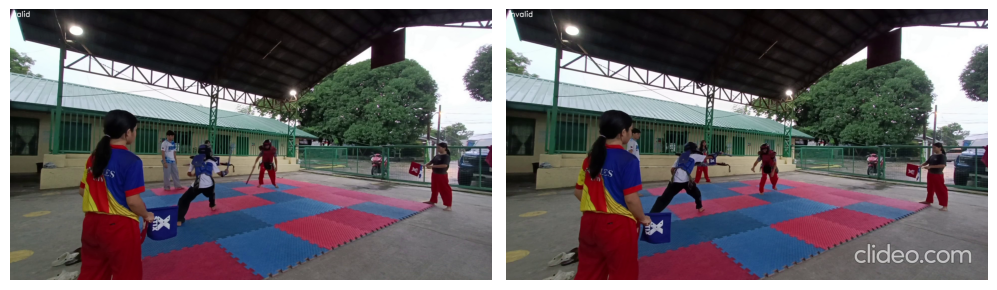

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories
all_classes_name = os.listdir("dataset/videos")

# Generate a list of 20 random values. The values will be between 0-1, where 2 is the total number of class in the dataset.
random_range = random.sample(
    range(len(all_classes_name)), min(20, len(all_classes_name))
)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_name = all_classes_name[random_index]

    # Retrieve the list of all the video files present in the randomly selected # Class Directory.
    video_files_names_list = os.listdir(f"dataset/videos/{selected_class_name}")

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(
        f"dataset/videos/{selected_class_name}/{selected_video_file_name}"
    )

    # Read the first frame of the video file.
    success, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(
        rgb_frame,
        selected_class_name,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
    )
    # Display the frame.
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Preprocessing the dataset


-Image Height & Weight: so that the frames will be fixed and consistent

-Sequence Length: the number of frames of for each video that we will extract

-Dataset Directory: set the directory of the datasets (it will be useful)

-Class List: define the dataset classes


In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the dataset.
DATASET_DIR = "dataset/videos"

# Specify the number of classes in the dataset.
CLASS_LIST = ["valid", "invalid"]

In [ ]:
def frames_extraction(video_path):
    """
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    """

    # Declare a list to store video frames.
    frame_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    vide_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(vide_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read the current frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frame_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frame_list

In [ ]:
def create_dataset():
    """
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    """

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_file_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASS_LIST):

        # Display the name of the class whose data is being extracted.
        print(f"Extracting Data of the Class {class_name}")

        # Get the list of video files present in the specific class name directory.
        file_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in file_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_file_paths

Create Dataset


In [22]:
features, labels, video_file_paths = create_dataset()

Extracting Data of the Class valid
Extracting Data of the Class invalid


Using Keras's to_categorical method to convert labels into one-hot-encoded vectors


In [23]:
one_hot_encoded_labels = to_categorical(labels)

Split the Data into Train ( 75% ) and Test Set ( 15% ).


In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size=0.15,
    shuffle=True,
    random_state=seed_constant,
)

Constructing the model


In [ ]:
def create_convlstm_model():
    """
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    """

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    model.add(
        ConvLSTM2D(
            filters=4,  # Number of output filters (channels)
            kernel_size=(3, 3),  # Size of convolutional kernel
            activation="tanh",  # Activation function
            data_format="channels_last",  # Input shape order (batch, time, height, width, channels)
            recurrent_dropout=0.2,  # Dropout rate for recurrent connections
            return_sequences=True,  # Return all output sequences (not just last step)
            input_shape=(
                SEQUENCE_LENGTH,
                IMAGE_HEIGHT,
                IMAGE_WIDTH,
                3,
            ),  # Input dimensions
        )
    )

    model.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),  # Pooling window dimensions (time, height, width)
            padding="same",  # Preserves spatial dimensions by padding zeros if needed
            data_format="channels_last",  # Input shape order (batch, time, height, width, channels)
        )
    )

    model.add(TimeDistributed(Dropout(0.2)))

    model.add(
        ConvLSTM2D(
            filters=8,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )

    model.add(
        MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last")
    )

    model.add(TimeDistributed(Dropout(0.2)))

    model.add(
        ConvLSTM2D(
            filters=14,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )

    model.add(
        MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last")
    )

    model.add(TimeDistributed(Dropout(0.2)))

    model.add(
        ConvLSTM2D(
            filters=16,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )

    model.add(
        MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last")
    )

    model.add(Flatten())

    model.add(Dense(len(CLASS_LIST), activation="softmax"))

    # Display the models summary.
    model.summary()

    #  Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 20, 222, 222,   │         1,024 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 20, 111, 111,   │             0 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 111, 111,   │             0 │
│ (TimeDistributed)               │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 20, 109, 109,   │         3,488 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 20, 55, 55, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 55, 55, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 20, 53, 53, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 20, 27, 27, 14) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 27, 27, 14) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 20, 25, 25, 16) │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 20, 13, 13, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 54080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │       108,162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,162 (551.41 KB)

 Trainable params: 141,162 (551.41 KB)

 Non-trainable params: 0 (0.00 B)

Train the model


In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=10, mode="min", restore_best_weights=True
)

# Compile the model and specify loss function, optimizer and metrics
convlstm_model.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"],
)

# Start training the model.
history = convlstm_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    callbacks=[early_stopping_callback],
    shuffle=True,
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6500 - loss: 0.9045 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 778ms/step - accuracy: 0.7833 - loss: 0.6180 - val_accuracy: 0.5000 - val_loss: 0.7675
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - accuracy: 0.3500 - loss: 0.8619 - val_accuracy: 0.5000 - val_loss: 0.7834
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 852ms/step - accuracy: 0.3500 - loss: 0.9457 - val_accuracy: 0.5000 - val_loss: 0.7333
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 836ms/step - accuracy: 0.3500 - loss: 0.8711 - val_accuracy: 0.5000 - val_loss: 0.7027
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step - accuracy: 0.3500 - loss: 0.7947 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step - accuracy: 0.3500 - loss: 0.7586 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 841ms/step - accuracy: 0.3500 - loss: 0.7521 - val_accuracy: 0.5000 - val_loss: 0

Evaluating the result base on the test datasets


In [33]:
model_evaluate_history = convlstm_model.evaluate(features_test, labels_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 1.0000 - loss: 8.7294e-04


Saving the Model


In [ ]:
convlstm_model.save("output/models/convlstm.h5")

Plotting the Accuracy Results


In [ ]:
def plot_metric(history):
    """
    This function will plot the metrics passed to it in a graph.
    Args:
        history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
    """

    # Plot the Graph.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker="o")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss", marker="o")
    plt.plot(history.history["val_loss"], label="Validation Loss", marker="o")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.grid(True)

    plt.tight_layout()
    plt.show()

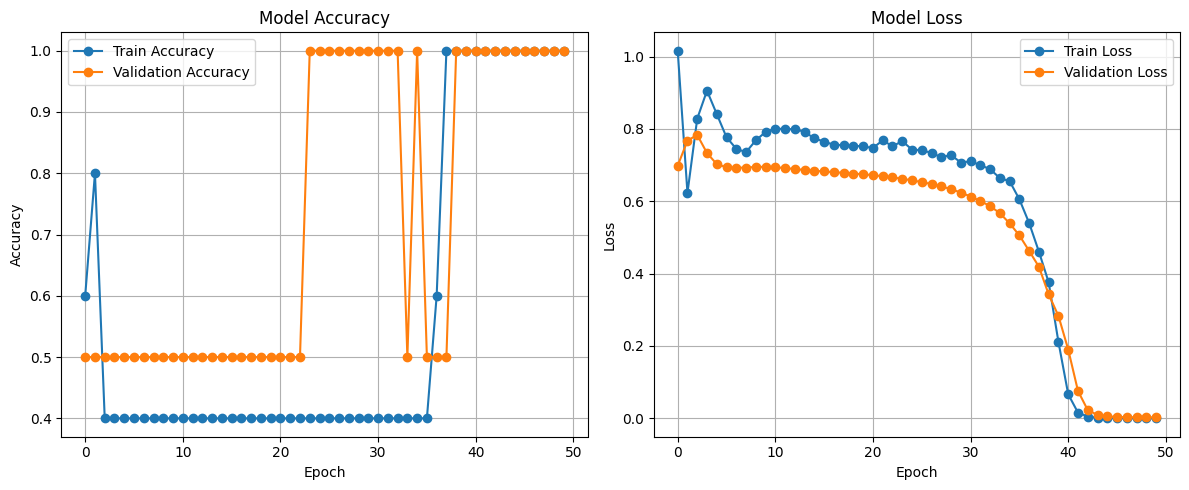

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history)

Sample test code to verify the accuracy of the result outside the test datasets


In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    """
    This function will perform action recognition on a video using the CONVLSTM model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    """

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Get the frames per second of the video.
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Specify the output file path where the video with predictions will be saved.
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(
        output_file_path, fourcc, fps, (original_video_width, original_video_height)
    )

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class = ""

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255.0

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Convert the frames queue into a numpy array and expand its dimensions to match the input shape of the model.
            input_frames = np.expand_dims(np.array(frames_queue), axis=0)

            # Predict the class of the action being performed in the video using the convlstm model.
            predictions = convlstm_model.predict(input_frames, verbose=0)

            # Get the class name using the retrieved index.
            predicted_class = CLASS_LIST[np.argmax(predictions)]

        # Write predicted class name on top of the frame.
        cv2.putText(
            frame,
            f"Prediction: {predicted_class}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
        )
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

    print(f"Prediction video saved to {output_file_path}")

In [ ]:
# Start the Prediction on the video file using the convlstm model.
predict_on_video(
    "test_vide2.mp4", "output/videos/cnnlstm_test_output2.mp4", SEQUENCE_LENGTH
)

Prediction video saved to output/videos/cnnlstm_test_output2.mp4
